### Import necessary libraries and set up environment.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import collections
import torch
import skirmish_env
import numpy as np
import itertools
import IPython
import random

# set up the gym environment
env = gym.make("skirmish_env:Skirmish-v0", render_mode=None)
# enable plot interactive mode
plt.ion()

### Define training parameters.

In [2]:
BATCH_SIZE = 128 # number of transitions sampled from the replay buffer
GAMMA = 0.99 # time discount factor
EPS_START = 0.9 # epsilon start value
EPS_END = 0.05 # epsilon end value
EPS_DECAY = 1000 # epsilon decay control (higher = slower decay)
TAU = 0.005 # update rate of target network
LR = 1e-4 # optimizer learning rate
EPISODES = 1000 # number of training episodes
MA_FRAME = 100 # moving average frame

### Create `ReplayMemory` object to collect training data and `DQN` for the Q function NN estimator.

In [3]:
Transition = collections.namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = collections.deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)
    
class DQN(torch.nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, 128)
        self.layer2 = torch.nn.Linear(128, 128)
        self.layer3 = torch.nn.Linear(128, n_actions)
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        return self.layer3(x)

### Set up `ReplayMemory`, DQN, and optimizer objects.

In [4]:
state, info = env.reset()
n_actions = env.action_space.n
n_observations = len(state)

policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


### Training loop

In [5]:
def optimize_model():
    # check that there's enough training data to optimize the model
    if len(memory) < BATCH_SIZE:
        return
    
    # take a batch sample from the training data
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # compute Q(state, action) for the batch sample
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # compute V(next_state) for the batch sample, using the "older" target_net
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [6]:
def plot_results(i_episode, episode_rewards):
    plt.figure(1)
    plt.clf()
    plt.title(f'Moving average of last {MA_FRAME} episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.plot( # average rewards
        np.arange(0, i_episode, step=1),
        np.array([np.mean(episode_rewards[np.max(i+1-MA_FRAME, 0):i+1]) for i in range(i_episode)]),
        label="Average rewards"
    )
    plt.plot( # win percentage
        np.arange(0, i_episode, step=1),
        np.array([np.mean(episode_rewards[np.max(i+1-MA_FRAME, 0):i+1] == 10) for i in range(i_episode)]),
        label="Win proportion"
    )
    plt.plot( # lose or tie percentage
        np.arange(0, i_episode, step=1),
        np.array([np.mean(episode_rewards[np.max(i+1-MA_FRAME, 0):i+1] == 0) for i in range(i_episode)]),
        label="Lose proportion"
    )
    plt.legend()
    plt.pause(0.001)

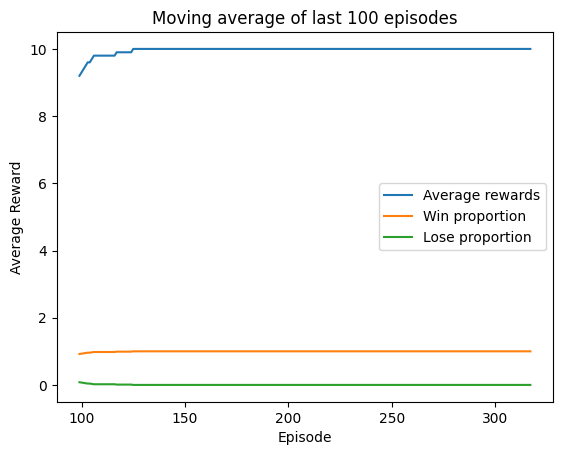

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [7]:
PLOT = True

total_steps_done = 0
episode_rewards = np.zeros(EPISODES)
for i_episode in range(EPISODES):
    # print(f"TRAINING EPISODE {i_episode}...")

    # initial state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    # take steps until done with episode
    for time_step in itertools.count():

        # select best action based on state with epsilon-greedy
        action = torch.tensor([[env.action_space.sample()]])
        if np.random.random() > EPS_END + (EPS_START - EPS_END) * np.exp(-1. * total_steps_done / EPS_DECAY):
            with torch.no_grad():
                action = policy_net(state).max(1).indices.view(1, 1)
        total_steps_done += 1

        # get the results of the action
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward])
        done = terminated or truncated
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
        episode_rewards[i_episode] += reward

        # store the transition and move to the next state
        memory.push(state, action, next_state, reward)
        state = next_state

        # optimize the policy network and update the target network's weights
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # print episode winner
            # print(f"FINISHED EPISODE {i_episode} WITH REWARD {reward}.")
            # print()
            
            # plot moving average of most recent episode rewards
            if PLOT:
                plot_results(i_episode, episode_rewards)
                IPython.display.display(plt.gcf())
                IPython.display.clear_output(wait=True)
            break

# print("COMPLETE")
if PLOT:
    plot_results(i_episode, episode_rewards)
    plt.ioff()
    plt.show()

In [8]:
PLOT = True

env_render = gym.make("skirmish_env:Skirmish-v0", render_mode="human")
state, info = env_render.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

# take steps until done with episode
for time_step in itertools.count():

    # select best action based on state with epsilon-greedy
    action = torch.tensor([[env_render.action_space.sample()]])
    if np.random.random() > EPS_END + (EPS_START - EPS_END) * np.exp(-1. * total_steps_done / EPS_DECAY):
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    total_steps_done += 1

    # get the results of the action
    observation, reward, terminated, truncated, _ = env_render.step(action.item())
    reward = torch.tensor([reward])
    done = terminated or truncated
    next_state = None if terminated else torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    episode_rewards[i_episode] += reward
    state = next_state

    if done:
        break

Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 27.952.

Rogue took action HEAL. Fighter took action MOVE.
Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 26.952.

Rogue took action HEAL. Fighter took action MOVE.
Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 25.952.

Rogue took action MOVE. Fighter took action MOVE.
Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 24.952.

Rogue took action MOVE. Fighter took action MOVE.
Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 23.952.

Rogue took action MOVE. Fighter took action MOVE.
Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 22.952.

Rogue took action ATTACK. Fighter took action MOVE.
Rogue has 5.000/5.000 hp and position 0.000.
Fighter has 3.000/3.000 hp and position 21.952.

Rogue took action MOVE. Fighter took act

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
